In [1]:
import numpy as np
import matplotlib.pyplot as plt
import h5py
import random
import sklearn
import collections
from sklearn.model_selection import train_test_split
import json
import pylab
from scipy.optimize import curve_fit
from tensorflow.keras import layers, Model
import tensorflow.keras.backend as K
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.models import load_model
from sklearn.metrics import roc_curve, auc

2024-03-23 14:49:43.718628: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-03-23 14:49:43.815524: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
import tensorflow as tf

# Check GPUs available
gpus = tf.config.list_physical_devices('GPU')
print(f"GPUs Available: {gpus}")

# Check if TensorFlow is currently executing eagerly (which means operations are executed as they are defined and is the default mode in TF 2.x)
print(f"Eager execution: {tf.executing_eagerly()}")

# If you have GPUs listed and eager execution is enabled, then operations should automatically run on the GPU if possible.
# To test if TensorFlow will place tensors and operations on the GPU by default, you can create a simple operation and see where it is placed:
if gpus:
    with tf.device('/GPU:0'):
        a = tf.constant([[1.0, 2.0, 3.0], [4.0, 5.0, 6.0]])
        print(a.device)
else:
    print("No GPU found!")

GPUs Available: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
Eager execution: True
/job:localhost/replica:0/task:0/device:GPU:0


2024-03-23 14:49:52.855205: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-03-23 14:49:52.877292: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-03-23 14:49:52.877542: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysf

In [3]:
# This is the list that will hold all of the data (data22 and MC)

datasets = []
pass_HLT = []
tags = ['data', 'HHbbttHadHad', 'ZZ4lep', 'Ztautau', 'jjJZ4', 'jjJZ2', 'qqa', 'LLP', 'dark_jets', 'dark_photons']

In [4]:
# Read EB data22 file

with h5py.File('../../../../ntuples/AOD_EB_ntuples_02-10-2024.h5', 'r') as hf:
    jets = hf['HLT_jets'][:]
    electrons = hf['electrons'][:]
    LRT_electrons = hf['LRT_electrons'][:]
    muons = hf['muons'][:]
    LRT_muons = hf['LRT_muons'][:]
    photons = hf['photons'][:]
    MET = hf['MET'][:].reshape(-1, 1, 4)  # Broadcasting MET
    pass_L1_unprescaled = hf["pass_L1_unprescaled"][:]
    pass_HLT_unprescaled = hf["pass_HLT_unprescaled"][:]
    EB_weights = hf["EB_weights"][:]

In [5]:
print(jets.shape)

(1019220, 10, 4)


In [6]:
# Collect only events that passed any of our unprescaled L1 list, and concatenate. Remove E.

pass_L1_idxs = (pass_L1_unprescaled == 1) # Indices of events that passed L1
pass_HLT_unprescaled = pass_HLT_unprescaled[pass_L1_idxs]
data = np.concatenate([jets[pass_L1_idxs], electrons[pass_L1_idxs], muons[pass_L1_idxs], photons[pass_L1_idxs], MET[pass_L1_idxs]], axis=1)
weights = EB_weights[pass_L1_idxs]
datasets.append(data[:, :, [0, 2, 3]])
pass_HLT.append(pass_HLT_unprescaled)

In [7]:
# Read MC data. Remove E.

filenames = ['HHbbttHadHad.h5', 
             'ZZ4lep.h5', 
             'Ztautau.h5', 
             'jjJZ4.h5', 
             'jjJZ2.h5', 
             'qqa.h5', 
             'HNL7p5_ctau1_eemu.h5',
             'Zprime2EJs.h5',
             'HAHMggfZdZd2l2nu.h5']
data_path = '../../../../ntuples/MC/'

for filename in filenames:
    with h5py.File(data_path+filename, 'r') as hf:
        jets = hf['HLT_jets'][:]
        electrons = hf['electrons'][:]
        LRT_electrons = hf['LRT_electrons'][:]
        muons = hf['muons'][:]
        LRT_muons = hf['LRT_muons'][:]
        photons = hf['photons'][:]
        MET = hf['MET'][:].reshape(-1, 1, 4)  # Broadcasting MET
        pass_HLT_unprescaled = hf['pass_HLT_unprescaled'][:]

        combined_data = np.concatenate([jets, electrons, muons, photons, MET], axis=1)
        datasets.append(combined_data[0:min(len(combined_data), 100000), :, [0, 2, 3]])
        pass_HLT.append(pass_HLT_unprescaled[0:min(len(combined_data), 100000)])

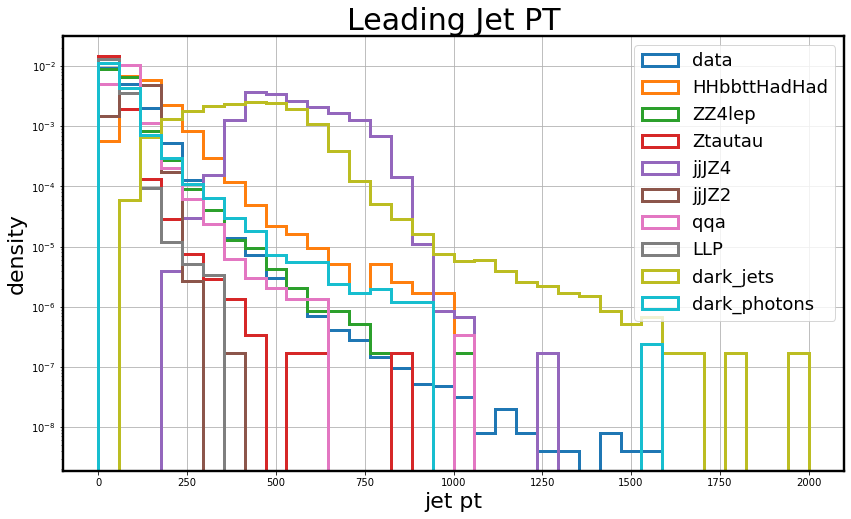

In [8]:
# Plotting pt distribtions of the jets from each dataset

plt.figure(figsize=(14, 8))
plt.rcParams['axes.linewidth'] = 2.4
bins = np.linspace(0, 2000, 35)
#bins=50

for i, tag in enumerate(tags):
    pt = datasets[i][:, 0, 0]
    nonzero_pt = pt[pt > 0]

    if i==0:
        nonzero_weights = weights[pt > 0]
        plt.hist(nonzero_pt, bins=bins, label=tag, histtype='step', density=True, fill=False, linewidth=3, weights=nonzero_weights)
    else:
        plt.hist(nonzero_pt, bins=bins, label=tag, histtype='step', density=True, fill=False, linewidth=3)

plt.yscale('log')
plt.xlabel('jet pt', fontsize=22)
plt.ylabel('density', fontsize=22)
plt.title('Leading Jet PT', fontsize=30)
plt.grid()
plt.legend(fontsize=18)
plt.show()

In [9]:
"""Met bias. For some events, MET was not calculated, so was written as -999.
We don't want this to impact training, so we map 0 --> 0.001 and -999 --> 0"""
for i, data in enumerate(datasets):

    # MET: 0 --> 0.001 and -999 --> 0 and nan --> 0
    MET_zeros = (data[:, 19, 0] == 0) # indices where MET=0
    MET_999 = ((data[:, 19, 0] == -999)) # indices where MET=-999 (not calculated)
    MET_nan = np.isnan(data[:, 19, 2])
    data[MET_zeros, 19, 0] = 0.001
    data[MET_999, 19, :] = 0
    data[MET_nan, 19, :] = 0

In [10]:
"""Normalize pt """
for i, data in enumerate(datasets):
    # sum of the pt and E in each event
    sum_pt = np.sum(data[:, :, 0], axis=1, keepdims=True)

    # If the sum is 0, set the sum to 1 to avoid division by 0
    sum_pt[sum_pt == 0] = 1

    # Divide pt and E by their respective sums
    data[:, :, 0] /= sum_pt

In [11]:
for i, dataset in enumerate(datasets):
    print(f'{tags[i]}: {dataset.shape}')

data: (224294, 20, 3)
HHbbttHadHad: (20000, 20, 3)
ZZ4lep: (100000, 20, 3)
Ztautau: (100000, 20, 3)
jjJZ4: (100000, 20, 3)
jjJZ2: (100000, 20, 3)
qqa: (50000, 20, 3)
LLP: (10000, 20, 3)
dark_jets: (100000, 20, 3)
dark_photons: (70000, 20, 3)


In [12]:
# Flatten ndarrays for use in DNN

for i, data in enumerate(datasets):
    datasets[i] = np.reshape(data, newshape=(-1, 60))

for i, data in enumerate(datasets):
    print(f'{tags[i]}: {data.shape}')

data: (224294, 60)
HHbbttHadHad: (20000, 60)
ZZ4lep: (100000, 60)
Ztautau: (100000, 60)
jjJZ4: (100000, 60)
jjJZ2: (100000, 60)
qqa: (50000, 60)
LLP: (10000, 60)
dark_jets: (100000, 60)
dark_photons: (70000, 60)


In [13]:
# Reparameterization
def sampling(args):
    """This function will be used in the reparameterization step of the VAE."""
    z_mean, z_log_var, latent_dim = args
    epsilon = K.random_normal(shape=(K.shape(z_mean)[0], latent_dim))
    std = K.exp(0.5 * z_log_var)
    return z_mean + std * epsilon

In [14]:
def create_VAE(input_dim, h_dim_1, h_dim_2, latent_dim, beta=0.4):
    """Creates a vae, and also the encoder and decoder in case of separate use.
    INPUTS:
    
    input_dim, h_dim_1, h_dim_2, latent_dim: These specify the stucture of the VAE.
    The shape will be input_dim --> h_dim_1 --> h_dim_2 --> latent_dim and then back up.

    beta: The parameter that determines the tuning between the KL and MSE loss.
    
    OUTPUTS:

    vae, encoder, decoder: keras models of the VAE, encoder (with reparameterization), and decoder.
    """

    # Encoder
    inputs = layers.Input(shape=(input_dim))
    x = layers.Dense(h_dim_1, activation='relu')(inputs)
    x = layers.Dense(h_dim_2, activation='relu')(x)
    z_mean = layers.Dense(latent_dim)(x)
    z_log_var = layers.Dense(latent_dim)(x)
    
    z = layers.Lambda(sampling)([z_mean, z_log_var, latent_dim]) # This wraps the 'sampling' function as a 'Layer' object
    
    # Decoder
    decoder_input = layers.Input(shape=(latent_dim,))
    x = layers.Dense(h_dim_2, activation='relu')(decoder_input)
    x = layers.Dense(h_dim_1, activation='relu')(x)
    outputs = layers.Dense(input_dim)(x)
    
    # Decoder Model
    decoder = Model(decoder_input, outputs)
    
    # VAE model
    vae_outputs = decoder(z)
    vae = Model(inputs, vae_outputs)
    
    # Encoder Model including reparameterization
    encoder = Model(inputs, [z_mean, z_log_var, z])
    
    # -------------------------------------------------------------------------------------------------------
    # Now let's define the loss function. We will use a combination of MSE and KL loss.

    recon_loss = K.mean(K.square(inputs - vae_outputs))
    kl_loss = -0.5 * K.mean(1 + z_log_var - K.square(z_mean) - K.exp(z_log_var))
    total_loss = (1 - beta) * recon_loss + beta * kl_loss
    vae.add_loss(total_loss)

    return vae, encoder, decoder

In [15]:
# Make train, test, val splits

TRAIN_SIZE = 0.6
VAL_SIZE = 0.2
TEST_SIZE = 0.2

X_train, X_, weights_train, weights_, pass_HLT_train, pass_HLT_ = train_test_split(datasets[0], weights, pass_HLT[0], train_size=TRAIN_SIZE)
X_val, X_test, weights_val, weights_test, pass_HLT_val, pass_HLT_test = train_test_split(X_, weights_, pass_HLT_, train_size=0.5)

print(f'X_train: {X_train.shape}')
print(f'X_val: {X_val.shape}')
print(f'X_test: {X_test.shape}')

X_train: (134576, 60)
X_val: (44859, 60)
X_test: (44859, 60)


In [19]:
# Initialize model
INPUT_DIM = X_train.shape[1]
H_DIM_1 = 32
H_DIM_2 = 16
LATENT_DIM = 4
vae, encoder, decoder = create_VAE(input_dim=INPUT_DIM, h_dim_1=H_DIM_1, h_dim_2=H_DIM_2, latent_dim=LATENT_DIM)
vae.summary()

Model: "model_4"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_3 (InputLayer)        [(None, 60)]                 0         []                            
                                                                                                  
 dense_7 (Dense)             (None, 32)                   1952      ['input_3[0][0]']             
                                                                                                  
 dense_8 (Dense)             (None, 16)                   528       ['dense_7[0][0]']             
                                                                                                  
 dense_9 (Dense)             (None, 4)                    68        ['dense_8[0][0]']             
                                                                                            

In [20]:
vae.compile(optimizer='adam')

In [21]:
# Define callbacks: early stopping and learning rate scheduler

STOP_PATIENCE = 8
LR_PATIENCE = 4

early_stopping = EarlyStopping(patience=STOP_PATIENCE, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=LR_PATIENCE, verbose=1)

callbacks = [early_stopping, reduce_lr]

In [22]:
NUM_EPOCHS = 100
BATCH_SIZE = 1024

In [23]:
history = vae.fit(x=X_train, y=X_train, validation_data=(X_val, X_val), epochs=NUM_EPOCHS, batch_size=BATCH_SIZE, callbacks=callbacks)

Epoch 1/100


2024-03-23 14:51:17.192816: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x20f07450 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2024-03-23 14:51:17.192895: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
2024-03-23 14:51:17.200385: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:255] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-03-23 14:51:17.359891: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:437] Could not create cudnn handle: CUDNN_STATUS_INTERNAL_ERROR
2024-03-23 14:51:17.360057: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:441] Memory usage: 851968 bytes free, 15835398144 bytes total.
2024-03-23 14:51:17.362351: W tensorflow/core/framework/op_kernel.cc:1828] OP_REQUIRES failed at xla_ops.cc:503 : FAILED_PRECONDITION: DNN library initialization failed. Look at the err

FailedPreconditionError: Graph execution error:

Detected at node 'Adam/StatefulPartitionedCall_12' defined at (most recent call last):
    File "/cvmfs/sft.cern.ch/lcg/releases/Python/3.9.12-9a1bc/x86_64-el9-gcc11-opt/lib/python3.9/runpy.py", line 197, in _run_module_as_main
      return _run_code(code, main_globals, None,
    File "/cvmfs/sft.cern.ch/lcg/releases/Python/3.9.12-9a1bc/x86_64-el9-gcc11-opt/lib/python3.9/runpy.py", line 87, in _run_code
      exec(code, run_globals)
    File "/usr/local/lib/swan/extensions/ipykernel/__main__.py", line 5, in <module>
      app.launch_new_instance()
    File "/cvmfs/sft.cern.ch/lcg/views/LCG_105a_cuda/x86_64-el9-gcc11-opt/lib/python3.9/site-packages/traitlets/config/application.py", line 1043, in launch_instance
      app.start()
    File "/usr/local/lib/swan/extensions/ipykernel/kernelapp.py", line 737, in start
      self.io_loop.start()
    File "/cvmfs/sft.cern.ch/lcg/views/LCG_105a_cuda/x86_64-el9-gcc11-opt/lib/python3.9/site-packages/tornado/platform/asyncio.py", line 199, in start
      self.asyncio_loop.run_forever()
    File "/cvmfs/sft.cern.ch/lcg/releases/Python/3.9.12-9a1bc/x86_64-el9-gcc11-opt/lib/python3.9/asyncio/base_events.py", line 601, in run_forever
      self._run_once()
    File "/cvmfs/sft.cern.ch/lcg/releases/Python/3.9.12-9a1bc/x86_64-el9-gcc11-opt/lib/python3.9/asyncio/base_events.py", line 1905, in _run_once
      handle._run()
    File "/cvmfs/sft.cern.ch/lcg/releases/Python/3.9.12-9a1bc/x86_64-el9-gcc11-opt/lib/python3.9/asyncio/events.py", line 80, in _run
      self._context.run(self._callback, *self._args)
    File "/usr/local/lib/swan/extensions/ipykernel/kernelbase.py", line 524, in dispatch_queue
      await self.process_one()
    File "/usr/local/lib/swan/extensions/ipykernel/kernelbase.py", line 513, in process_one
      await dispatch(*args)
    File "/usr/local/lib/swan/extensions/ipykernel/kernelbase.py", line 418, in dispatch_shell
      await result
    File "/usr/local/lib/swan/extensions/ipykernel/kernelbase.py", line 758, in execute_request
      reply_content = await reply_content
    File "/usr/local/lib/swan/extensions/ipykernel/ipkernel.py", line 433, in do_execute
      res = shell.run_cell(code, store_history=store_history, silent=silent)
    File "/usr/local/lib/swan/extensions/ipykernel/zmqshell.py", line 549, in run_cell
      return super().run_cell(*args, **kwargs)
    File "/cvmfs/sft.cern.ch/lcg/views/LCG_105a_cuda/x86_64-el9-gcc11-opt/lib/python3.9/site-packages/IPython/core/interactiveshell.py", line 2898, in run_cell
      result = self._run_cell(
    File "/cvmfs/sft.cern.ch/lcg/views/LCG_105a_cuda/x86_64-el9-gcc11-opt/lib/python3.9/site-packages/IPython/core/interactiveshell.py", line 2944, in _run_cell
      return runner(coro)
    File "/cvmfs/sft.cern.ch/lcg/views/LCG_105a_cuda/x86_64-el9-gcc11-opt/lib/python3.9/site-packages/IPython/core/async_helpers.py", line 68, in _pseudo_sync_runner
      coro.send(None)
    File "/cvmfs/sft.cern.ch/lcg/views/LCG_105a_cuda/x86_64-el9-gcc11-opt/lib/python3.9/site-packages/IPython/core/interactiveshell.py", line 3169, in run_cell_async
      has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
    File "/cvmfs/sft.cern.ch/lcg/views/LCG_105a_cuda/x86_64-el9-gcc11-opt/lib/python3.9/site-packages/IPython/core/interactiveshell.py", line 3361, in run_ast_nodes
      if (await self.run_code(code, result,  async_=asy)):
    File "/cvmfs/sft.cern.ch/lcg/views/LCG_105a_cuda/x86_64-el9-gcc11-opt/lib/python3.9/site-packages/IPython/core/interactiveshell.py", line 3441, in run_code
      exec(code_obj, self.user_global_ns, self.user_ns)
    File "/tmp/ipykernel_1894/1328589423.py", line 1, in <module>
      history = vae.fit(x=X_train, y=X_train, validation_data=(X_val, X_val), epochs=NUM_EPOCHS, batch_size=BATCH_SIZE, callbacks=callbacks)
    File "/cvmfs/sft.cern.ch/lcg/views/LCG_105a_cuda/x86_64-el9-gcc11-opt/lib/python3.9/site-packages/keras/src/utils/traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "/cvmfs/sft.cern.ch/lcg/views/LCG_105a_cuda/x86_64-el9-gcc11-opt/lib/python3.9/site-packages/keras/src/engine/training.py", line 1742, in fit
      tmp_logs = self.train_function(iterator)
    File "/cvmfs/sft.cern.ch/lcg/views/LCG_105a_cuda/x86_64-el9-gcc11-opt/lib/python3.9/site-packages/keras/src/engine/training.py", line 1338, in train_function
      return step_function(self, iterator)
    File "/cvmfs/sft.cern.ch/lcg/views/LCG_105a_cuda/x86_64-el9-gcc11-opt/lib/python3.9/site-packages/keras/src/engine/training.py", line 1322, in step_function
      outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/cvmfs/sft.cern.ch/lcg/views/LCG_105a_cuda/x86_64-el9-gcc11-opt/lib/python3.9/site-packages/keras/src/engine/training.py", line 1303, in run_step
      outputs = model.train_step(data)
    File "/cvmfs/sft.cern.ch/lcg/views/LCG_105a_cuda/x86_64-el9-gcc11-opt/lib/python3.9/site-packages/keras/src/engine/training.py", line 1084, in train_step
      self.optimizer.minimize(loss, self.trainable_variables, tape=tape)
    File "/cvmfs/sft.cern.ch/lcg/views/LCG_105a_cuda/x86_64-el9-gcc11-opt/lib/python3.9/site-packages/keras/src/optimizers/optimizer.py", line 544, in minimize
      self.apply_gradients(grads_and_vars)
    File "/cvmfs/sft.cern.ch/lcg/views/LCG_105a_cuda/x86_64-el9-gcc11-opt/lib/python3.9/site-packages/keras/src/optimizers/optimizer.py", line 1230, in apply_gradients
      return super().apply_gradients(grads_and_vars, name=name)
    File "/cvmfs/sft.cern.ch/lcg/views/LCG_105a_cuda/x86_64-el9-gcc11-opt/lib/python3.9/site-packages/keras/src/optimizers/optimizer.py", line 652, in apply_gradients
      iteration = self._internal_apply_gradients(grads_and_vars)
    File "/cvmfs/sft.cern.ch/lcg/views/LCG_105a_cuda/x86_64-el9-gcc11-opt/lib/python3.9/site-packages/keras/src/optimizers/optimizer.py", line 1260, in _internal_apply_gradients
      return tf.__internal__.distribute.interim.maybe_merge_call(
    File "/cvmfs/sft.cern.ch/lcg/views/LCG_105a_cuda/x86_64-el9-gcc11-opt/lib/python3.9/site-packages/keras/src/optimizers/optimizer.py", line 1352, in _distributed_apply_gradients_fn
      distribution.extended.update(
    File "/cvmfs/sft.cern.ch/lcg/views/LCG_105a_cuda/x86_64-el9-gcc11-opt/lib/python3.9/site-packages/keras/src/optimizers/optimizer.py", line 1347, in apply_grad_to_update_var
      return self._update_step_xla(grad, var, id(self._var_key(var)))
Node: 'Adam/StatefulPartitionedCall_12'
DNN library initialization failed. Look at the errors above for more details.
	 [[{{node Adam/StatefulPartitionedCall_12}}]] [Op:__inference_train_function_176754]

In [ ]:
predictions = []
y_true = []


predictions.append(vae.predict(X_test))
y_true.append(X_test)

for i, data in enumerate(datasets):
    if i==0: continue

    y_true.append(data)
    predictions.append(vae.predict(data))

In [24]:
def mse_loss(true, prediction):
    loss = np.mean(np.square(true - prediction), axis=-1)
    return loss

In [25]:
def AD_score(y, x):
    # masked mse
    mask = (y != 0) & (y != -999)
    _x = x * mask
    _y = y * mask
    return (mse_loss(_y, _x))

In [26]:
total_loss = []

for i, prediction in enumerate(predictions):
    total_loss.append(AD_score(y_true[i], prediction))

<Figure size 1296x720 with 0 Axes>

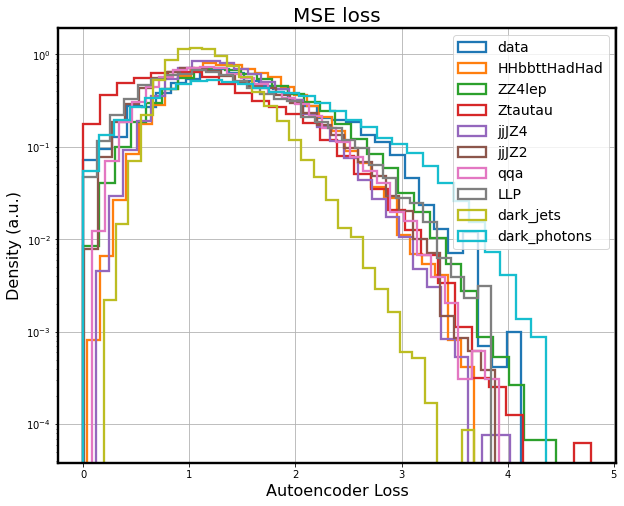

In [27]:
plt.figure(figsize=(18, 10))
plt.rcParams['axes.linewidth'] = 2.4

#bins = np.linspace(0, 50000, num=30)
bins=30
plt.figure(figsize=(10,8))
for i, tag in enumerate(tags):
    if i==0:
        plt.hist(total_loss[i], bins=bins, label=tag, density = True, histtype='step', fill=False, linewidth=2.3, weights=weights_test)
    else:
        plt.hist(total_loss[i], bins=bins, label=tag, density = True, histtype='step', fill=False, linewidth=2.3)


plt.yscale('log')
plt.xlabel("Autoencoder Loss", fontsize=16)
plt.ylabel("Density (a.u.)", fontsize=16)
plt.title('MSE loss', fontsize=20)
plt.legend(loc='best', fontsize=14)
plt.grid()
#plt.xlim(0, 0.2 * pow(10, 6))
plt.show()

data: TPR at FPR of 10^-4 is 0.0001 with threshold 4.0954


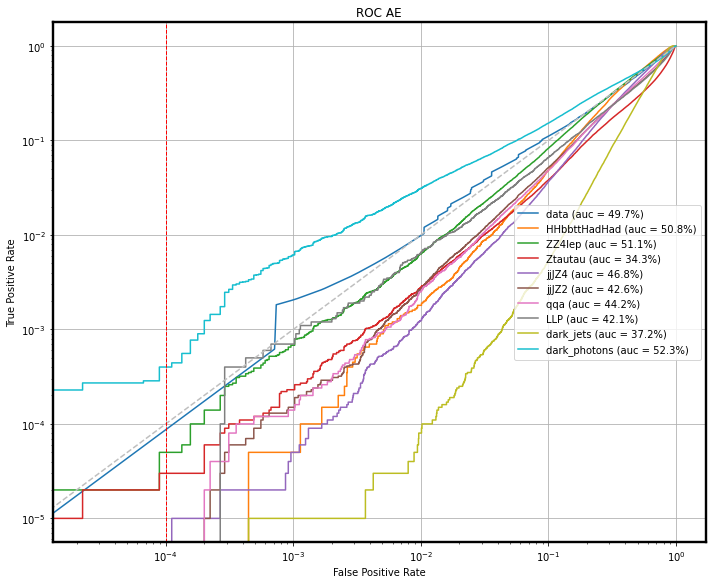

In [28]:
target_background = np.zeros(total_loss[0].shape[0])

plt.figure(figsize=(10,8))

for i, label in enumerate(tags):
    # Combine true labels, anomaly=1 and background=0
    trueVal = np.concatenate((np.ones(total_loss[i].shape[0]), target_background))
    
    # Combine predictions from current dataset and background
    predVal_loss = np.concatenate((total_loss[i], total_loss[0]))
    
    # Include weights for the EB data and assign no weight (or equal weight) for the other dataset
    if i == 0:  # For the EB data
        sample_weights = np.concatenate((weights_test, np.ones_like(target_background)))
    else:  # For the MC datasets, assume equal weight
        sample_weights = np.concatenate((np.ones(total_loss[i].shape[0]), np.ones_like(target_background)))

    # Calculate ROC curve and AUC, including weights
    fpr_loss, tpr_loss, threshold_loss = roc_curve(y_true=trueVal, y_score=predVal_loss, sample_weight=sample_weights)
    auc_loss = auc(fpr_loss, tpr_loss)

    # Plot ROC curve
    plt.plot(fpr_loss, tpr_loss, "-", label='%s (auc = %.1f%%)' % (label, auc_loss*100.), linewidth=1.5)

    # Find index where FPR is closest to 10^-4 and print TPR and threshold for that index
    if i ==0: 
        target_fpr = 10**-4
        idx = np.argmin(np.abs(fpr_loss - target_fpr))
        print(f"{label}: TPR at FPR of 10^-4 is {tpr_loss[idx]:.4f} with threshold {threshold_loss[idx]:.4f}")
        threshold = threshold_loss[idx]

# Set log scale for x and y axis
plt.semilogx()
plt.semilogy()

# Plot aesthetics and layout
plt.ylabel("True Positive Rate")
plt.xlabel("False Positive Rate")
plt.legend(loc='center right')
plt.grid(True)
plt.tight_layout()

# Additional plot elements
plt.plot(np.linspace(0, 1), np.linspace(0, 1), '--', color='0.75')
plt.axvline(0.0001, color='red', linestyle='dashed', linewidth=1)  # Threshold value
plt.title("ROC AE")
plt.show()

In [29]:
"""Print the HLT overlap (the percentage of events we found as anomalous that
are already being triggered by the HLT)"""

for i, tag in enumerate(tags):
    anomaly_idxs = (total_loss[i] > threshold)
    HLT_overlap = 0

    if i ==0:
        for a, h in zip(anomaly_idxs, pass_HLT_test):
            if a==1 and h==1:
                HLT_overlap += 1
        HLT_overlap /= np.sum(anomaly_idxs)
    else:
        for a, h in zip(anomaly_idxs, pass_HLT[i]):
            if a==1 and h==1:
                HLT_overlap += 1
        HLT_overlap /= np.sum(anomaly_idxs)

    print(f'-----\n{tag}:')
    print(f'HLT overlap: {HLT_overlap}')
    print(f'percentage of events that passed some HLT trigger: {np.sum(pass_HLT_test) / len(pass_HLT_test)}')
    print(f'percentage of events that we tagged as anomalous: {np.sum(anomaly_idxs) / len(anomaly_idxs)}')
    print(f'number of events that we tagged as anomalous: {np.sum(anomaly_idxs)}')

-----
data:
HLT overlap: 0.0
percentage of events that passed some HLT trigger: 0.03218975010588734
percentage of events that we tagged as anomalous: 6.687621213134488e-05
number of events that we tagged as anomalous: 3
-----
HHbbttHadHad:
HLT overlap: nan
percentage of events that passed some HLT trigger: 0.03218975010588734
percentage of events that we tagged as anomalous: 0.0
number of events that we tagged as anomalous: 0


/tmp/ipykernel_351/3977479557.py:17: RuntimeWarning: invalid value encountered in long_scalars
  HLT_overlap /= np.sum(anomaly_idxs)


-----
ZZ4lep:
HLT overlap: 1.0
percentage of events that passed some HLT trigger: 0.03218975010588734
percentage of events that we tagged as anomalous: 2e-05
number of events that we tagged as anomalous: 2
-----
Ztautau:
HLT overlap: 0.0
percentage of events that passed some HLT trigger: 0.03218975010588734
percentage of events that we tagged as anomalous: 2e-05
number of events that we tagged as anomalous: 2
-----
jjJZ4:
HLT overlap: nan
percentage of events that passed some HLT trigger: 0.03218975010588734
percentage of events that we tagged as anomalous: 0.0
number of events that we tagged as anomalous: 0
-----
jjJZ2:
HLT overlap: nan
percentage of events that passed some HLT trigger: 0.03218975010588734
percentage of events that we tagged as anomalous: 0.0
number of events that we tagged as anomalous: 0
-----
qqa:
HLT overlap: nan
percentage of events that passed some HLT trigger: 0.03218975010588734
percentage of events that we tagged as anomalous: 0.0
number of events that we tag

In [41]:
vae.save('../../trained_models/VAE_norm_v2.keras')

***
<hr style="border:2px solid #F08080">

In [73]:
HLT_rate = np.sum(weights * pass_HLT[0]) / np.sum(weights)
print(f'HLT rate: {HLT_rate * 100000}')
print(f'HLT acceptance: {HLT_rate}')
print(f'HLT rejection: {1/HLT_rate}')

HLT rate: 1663.0022409427372
HLT acceptance: 0.01663002240942737
HLT rejection: 60.13221001031913


In [75]:
HLT_numerator = 0
HLT_denominator = 0
HLT_AD_numerator = 0
HLT_AD_denominator = 0

for i, tag in enumerate(tags):
    anomaly_idxs = (total_loss[i] > threshold)
    if i == 0:
        HLT_numerator += np.sum(weights_test * pass_HLT_test)
        HLT_denominator += np.sum(weights_test)

        HLT_AD_numerator += np.sum(weights_test * np.bitwise_or(anomaly_idxs, pass_HLT_test))
        HLT_AD_denominator += np.sum(weights_test)
    else:
        HLT_numerator += np.sum(pass_HLT[i][0:min(len(anomaly_idxs), 100000)])
        HLT_denominator += len(anomaly_idxs)

        HLT_AD_numerator += np.sum(np.bitwise_or(anomaly_idxs, pass_HLT[i][0:min(len(anomaly_idxs), 100000)]))
        HLT_AD_denominator += len(anomaly_idxs)


HLT_acceptance = HLT_numerator / HLT_denominator
HLT_AD_acceptance = HLT_AD_numerator / HLT_AD_denominator

print(f'HLT rate: {HLT_acceptance * 100000}')
print(f'HLT + AD rate: {HLT_AD_acceptance * 100000}')
print(f'rate added by AD: {(HLT_AD_acceptance - HLT_acceptance) * 100000}')

HLT rate: 2325.021205187533
HLT + AD rate: 2334.8736840624424
rate added by AD: 9.852478874909643
